In [1]:
from gerrychain import Graph

In [2]:
# Read Alabama county graph from the json file "COUNTY_01.json"

filename = 'COUNTY_01.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filename )

In [3]:
# For each node, print the node #, county name, and its population
for node in G.nodes:
    name = G.nodes[node]["NAME10"]
    population = G.nodes[node]['TOTPOP']
    x_coordinate = G.nodes[node]['C_X']
    y_coordinate = G.nodes[node]['C_Y']
    print("Node",node,"is",name,"County, which has population",population,"and is centered at (",x_coordinate,",",y_coordinate,")")

Node 0 is Barbour County, which has population 27457 and is centered at ( -85.39319697174619 , 31.869603217898423 )
Node 1 is Clay County, which has population 13932 and is centered at ( -85.86054705944194 , 33.269085886198276 )
Node 2 is Marengo County, which has population 21027 and is centered at ( -87.78951928523522 , 32.24761342168653 )
Node 3 is Houston County, which has population 101547 and is centered at ( -85.30251975426631 , 31.15318422009409 )
Node 4 is Cherokee County, which has population 25989 and is centered at ( -85.60379382552829 , 34.175955543616034 )
Node 5 is Baldwin County, which has population 182265 and is centered at ( -87.74984469453685 , 30.6609738924624 )
Node 6 is Conecuh County, which has population 13228 and is centered at ( -86.99368134370104 , 31.42926727158543 )
Node 7 is Cleburne County, which has population 14972 and is centered at ( -85.51876791986888 , 33.67455784656897 )
Node 8 is Jefferson County, which has population 658466 and is centered at ( 

In [12]:
# pip install geopy

!pip install geopy

In [13]:
import geopy

In [14]:
# what is the "distance" between Barbour County (node 0), Shelby County (node 15), and Walker County (node 23)?
from geopy.distance import geodesic

# Store centroid location as ( long, lat )
Barbour = ( G.nodes[0]['C_Y'],  G.nodes[0]['C_X'] )
Shelby = ( G.nodes[15]['C_Y'], G.nodes[15]['C_X'] )
Walker = ( G.nodes[23]['C_Y'], G.nodes[23]['C_X'] )

# Print the distance in miles
print("Barbour -> Shelby:",geodesic(Barbour, Shelby).miles)
print("Shelby -> Walker:",geodesic(Shelby, Walker).miles)
print("Walker -> Barbour:",geodesic(Walker, Barbour).miles)

Barbour -> Shelby: 121.2644116391872
Shelby -> Walker: 52.255718525283626
Walker -> Barbour: 173.27867565607963


In [15]:
# create distance dictionary
dist = dict()
for i in G.nodes:
    for j in G.nodes:
        loc_i = ( G.nodes[i]['C_Y'],  G.nodes[i]['C_X'] )
        loc_j = ( G.nodes[j]['C_Y'],  G.nodes[j]['C_X'] )
        dist[i,j] = geodesic(loc_i,loc_j).miles

In [16]:
# check the dictionary by printing the Barbour County -> Shelby County distance
print("Barbour -> Shelby:",dist[0,15])

Barbour -> Shelby: 121.2644116391872


In [17]:
# Let's impose a 1% population deviation (+/- 0.5%)
deviation = 0.01

import math
k = 7          # number of districts
total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 679406 and U = 686233 and k = 7


In [18]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create x[i,j] variable which equals one when county i 
#    is assigned to (the district centered at) county j
x = m.addVars(G.nodes, G.nodes, vtype=GRB.BINARY)

Academic license - for non-commercial use only - expires 2021-06-24
Using license file C:\Users\Louisa\gurobi.lic


In [19]:
# objective is to minimize the moment of inertia: d^2 * p * x
m.setObjective( gp.quicksum( dist[i,j]*dist[i,j]*G.nodes[i]['TOTPOP']*x[i,j] 
                            for i in G.nodes for j in G.nodes), GRB.MINIMIZE )

In [20]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in G.nodes) == 1 for i in G.nodes)

# add constraint saying there should be k district centers
m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )

# add constraints that say: if j roots a district, then its population is between L and U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L * x[j,j] for j in G.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U * x[j,j] for j in G.nodes )

# add coupling constraints saying that if i is assigned to j, then j is a center.
m.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )

m.update()

In [21]:
# Add contiguity constraints

import networkx as nx
DG = nx.DiGraph(G)

# Add variable f[j,u,v] which equals the amount of flow (originally from j) that is sent across arc (u,v)
f = m.addVars( DG.nodes, DG.edges, vtype=GRB.CONTINUOUS)
M = DG.number_of_nodes()-1

# Add constraint saying that node j cannot receive flow of its own type
m.addConstrs( gp.quicksum( f[j,u,j] for u in DG.neighbors(j) ) == 0 for j in DG.nodes )

# Add constraints saying that node i can receive flow of type j only if i is assigned to j
m.addConstrs( gp.quicksum( f[j,u,i] for u in DG.neighbors(i)) <= M * x[i,j] for i in DG.nodes for j in DG.nodes if i != j )

# If i is assigned to j, then i should consume one unit of j flow. 
#    Otherwise, i should consume no units of j flow.
m.addConstrs( gp.quicksum( f[j,u,i] - f[j,i,u] for u in DG.neighbors(i)) == x[i,j] for i in DG.nodes for j in DG.nodes if i != j )

m.update()

In [22]:
# solve, making sure to set a 0.00% MIP gap tolerance(!)
m.Params.MIPGap = 0.0
m.optimize()

Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 13602 rows, 27403 columns and 99280 nonzeros
Model fingerprint: 0x8806bbad
Variable types: 22914 continuous, 4489 integer (4489 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+05]
  Objective range  [4e+06, 4e+10]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1027 rows and 2760 columns
Presolve time: 1.12s
Presolved: 12575 rows, 24643 columns, 90388 nonzeros
Variable types: 20420 continuous, 4223 integer (4223 binary)

Root relaxation: objective 5.661390e+09, 1722 iterations, 0.37 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dep

In [23]:
print("The moment of inertia objective is",m.objval)

# retrieve the districts and their populations
centers = [j for j in G.nodes if x[j,j].x > 0.5 ]
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in centers]
district_counties = [ [ G.nodes[i]["NAME10"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])

The moment of inertia objective is 6409755608.475345
District 0 has population 681381 and contains counties ['Jefferson', 'Bibb']
District 1 has population 680437 and contains counties ['Madison', 'Limestone', 'Franklin', 'Lauderdale', 'Jackson', 'Marion', 'Colbert']
District 2 has population 684669 and contains counties ['Cherokee', 'Cleburne', 'Marshall', 'Morgan', 'Etowah', 'Lawrence', 'DeKalb', 'St. Clair', 'Blount', 'Cullman']
District 3 has population 683280 and contains counties ['Dallas', 'Shelby', 'Walker', 'Pickens', 'Tuscaloosa', 'Sumter', 'Perry', 'Chilton', 'Greene', 'Winston', 'Lamar', 'Choctaw', 'Fayette', 'Hale']
District 4 has population 684512 and contains counties ['Clay', 'Macon', 'Autauga', 'Talladega', 'Tallapoosa', 'Calhoun', 'Elmore', 'Chambers', 'Bullock', 'Coosa', 'Russell', 'Randolph', 'Lee']
District 5 has population 682766 and contains counties ['Marengo', 'Baldwin', 'Mobile', 'Washington', 'Clarke', 'Monroe']
District 6 has population 682691 and contains c

In [24]:
# Let's draw it on a map
import geopandas as gpd

In [25]:
# Read Oklahoma county shapefile from "OK_county.shp"

filename = 'AL_counties.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filename )

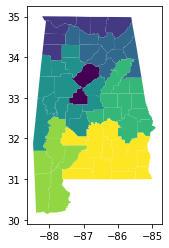

In [26]:
# Which district is each county assigned to?
assignment = [ -1 for u in G.nodes ]
    
# for each district j
for j in range(len(districts)):
    
    # for each node i in this district
    for i in districts[j]:
        
        # What is its GEOID?
        geoID = G.nodes[i]["GEOID10"]
        
        # Need to find this GEOID in the dataframe
        for u in G.nodes:
            if geoID == df['GEOID10'][u]: # Found it
                assignment[u] = j # Node u from the dataframe should be assigned to district j

# Now add the assignments to a column of the dataframe and map it
df['assignment'] = assignment
my_fig = df.plot(column='assignment').get_figure()